In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import copy
import gc

## Instructions

<b>Dependencies required:</b>
- tensorflow2.x
- keras (comes from tensorflow.keras)
- numpy
- copy
- sklearn
- matplotlib

<b>Setup requirements:</b>
- Set up a folder named 'Images' (same directory as this Jupyter Notebook) to store the output images from the model
- Set up a folder named 'Caches' (same directory as this Jupyter Notebook) to store the caches from the model
- Download the Tiny ImageNet dataset and put it in the same directory as this Jupyter Notebook. Dataset Download Link: https://tiny-imagenet.herokuapp.com/

<b>Section descriptions:</b>
- <b>Section 1: Generic Initialization</b>
    - Run all the code under Section 1. These are the code to define the main functions required for the experiments
- <b>Section 2: Tiny ImageNet</b>
    - Run the codes here for experiments on the Tiny ImageNet dataset
        - Section 2.1: Customize Model
            - Allows you to customize the model used for the experiment.
        - Section 2.2: Evaluate Model
            - Allows you to run code to evaluate performance of various metrics.

## Section 1: Generic Initialization

In [5]:
def flattenmask(mask):
    """Returns the nodes of mask flattened
    Input:
    mask - the mask position, in dictionary form
    Output:
    maskflatten - the mask position, flattened out in 1D array
    """
    maskflatten = []
    for k, v in mask.items():
        curmask = v.flatten()
        maskflatten = np.hstack([maskflatten, curmask])
    return maskflatten

def getmask(layers, mask, maskflatten, mask_type = 'min', percentile = 0.2, printactivation = False, dropOne = False):
    """ Updates mask after each training cycle
    Inputs:
    layers - Predicted node value per layer
    mask - current mask
    mask_type - type of mask: min, max, random, min_layer, max_layer, random_layer
    maskflatten - Flattened masked indices per layer (1 for mask, 0 for no mask)
    percentile - percentage of nodes remaining to be masked
    printactivation - Boolean. Whether to print the activations per layer
    dropOne - Boolean. Whether to drop only one node/filter at a time
    
    Output:
    mask - final masks after masking percentile proportion of remaining nodes
    """
    nodevalues = []
    layermeans = {}
    
    # if only drop one, then percentile is 0
    if dropOne:
        percentile = 0
    
    # if only one layer
    if(len(mask)==1):
        layermeans[0] = np.mean(np.abs(layers), axis = 0).ravel()
        nodevalues = np.hstack([nodevalues, layermeans[0]])
        if printactivation:
            print('Layer activations:', layermeans[0])
        
    # if more than one layer
    else:
        for i in range(len(mask)):
            layermeans[i] = np.mean(np.abs(layers[i]), axis = 0).ravel()
            nodevalues = np.hstack([nodevalues, layermeans[i]])
            if printactivation:
                print('Layer activations:', layermeans[i])

    # remove only those in maskindex
    maskflatten = np.ravel(np.where(maskflatten == 1))
    
    # find out the threshold node/filter value to remove
    if len(maskflatten) > 0:
        # for max mask
        if mask_type == 'max':
            sortedvalues = -np.sort(-nodevalues[maskflatten])
            index = int((percentile)*len(sortedvalues))
            maxindex = sortedvalues[index]
            
        # for min or % mask
        else:
            sortedvalues = np.sort(nodevalues[maskflatten])
            index = int(percentile*len(sortedvalues))
            maxindex = sortedvalues[index]
                           
    # Calculate the number of nodes to remove
    nummask = 0
    
    for v in mask.values():
        nummask += np.sum(v)
    
    totalnodes = int((percentile)*nummask)
    
    if dropOne:
        totalnodes = 1

    # remove at least one node
    if (totalnodes == 0):
        totalnodes = 1
    
    # identify the indices to drop for random mask
    if mask_type == 'random':
        indices = np.random.permutation(maskflatten)
        # take only the first totalnodes number of nodes
        indices = indices[:totalnodes]
        
        dropmaskindex = {}
        startindex = 0
        # assign nodes/filters to drop for each layer in dropmaskindex
        for k, v in mask.items():
            nummask += np.sum(v)
            dropmaskindex[k] = indices[(indices>=startindex) & (indices < startindex + len(v))] - startindex
            startindex += len(v)
        
    for i, layermean in layermeans.items():

        #only if there is something to drop in current mask
        if(np.sum(mask[i])>0):
            # Have different indices for different masks
            if mask_type == 'max':
                indices = np.ravel(np.where(layermean>=maxindex))
                curindices = np.ravel(np.where(mask[i].ravel()))
                indices = [j for j in indices if j in curindices]
            # global random mask or layer random mask
            elif mask_type == 'random_layer':
                indices = np.ravel(np.where(mask[i].ravel()))
                curindices = np.ravel(np.where(mask[i].ravel()))
            elif mask_type == 'random':
                indices = dropmaskindex[i]
                curindices = np.ravel(np.where(mask[i].ravel()))
            # layer-wise max mask
            elif mask_type == 'max_layer':
                sortedvalues = -np.sort(-layermean[mask[i]==1])
                index = int((percentile)*len(sortedvalues))
                maxindex = sortedvalues[index]
                indices = np.ravel(np.where(layermean>=maxindex))
                curindices = np.ravel(np.where(mask[i].ravel()))
                indices = [j for j in indices if j in curindices]
            # layer-wise min mask
            elif mask_type == 'min_layer':
                sortedvalues = np.sort(layermean[mask[i]==1])
                index = int((percentile)*len(sortedvalues))
                maxindex = sortedvalues[index]
                indices = np.ravel(np.where(layermean<=maxindex))
                curindices = np.ravel(np.where(mask[i].ravel()))
                indices = [j for j in indices if j in curindices]
            # if this is min mask or % based mask
            else:
                indices = np.ravel(np.where(layermean<=maxindex))
                curindices = np.ravel(np.where(mask[i].ravel()))
                indices = [j for j in indices if j in curindices]
                
        else:
            #default
            indices = np.ravel(np.where(mask[i]==1))

        # shuffle the indices only if we are not dropping one node/filter
        if (dropOne == False):
            indices = np.random.permutation(indices)

        newmask = mask[i].ravel()

        # for layer masks, total nodes dropped is by percentile of the layer of each mask
        if(mask_type == 'random_layer') or mask_type == 'min_layer' or mask_type == 'max_layer':
            initialpercent = np.sum(mask[i])*1.0/len(mask[i].ravel())
            totalnodes = int(initialpercent*(percentile)*len(mask[i].ravel()))

            # remove at least 1 node
            if (totalnodes == 0):
                totalnodes = 1

        if(len(indices)>0):

            # remove at most totalnodes number of nodes
            if(len(indices)>totalnodes):
                indices = indices[:totalnodes]

            # remove nodes
            newmask[indices] = 0

            # updated totalnodes to be removed
            totalnodes = totalnodes - len(indices)

        # reshape to fit new mask
        mask[i] = newmask.reshape(mask[i].shape)

    return mask

def resetmask(mask):
    """Resets mask to initial start state of all ones"""
    for k, v in mask.items():
        mask[k] = np.ones_like(v)
    
    return mask

def comparemask(mask1, mask2):
    """ Compares how similar both masks (mask1, mask2) are and returns a percentage similarity """
    count = 0
    totalcount = 0
    for k, v in mask1.items():
        count += np.sum(mask1[k] == mask2[k])
        totalcount += len(mask1[k].ravel())
        
    return count/totalcount

def percentmask(mask):
    """Returns the percentage of mask that contains 1s"""
    nummask = 0
    totalmask = 0
    
    for v in mask.values():
        nummask += np.sum(v)
        totalmask += len(v.ravel())
        
    return nummask/totalmask

In [10]:
def printgraph(cache, name, numtrials = 15, oracle = False):
    """Function to print graph
    Input: 
    cache - Cache containing accuracies, losses, early stopping iteration and oracle comparison
    name - name of model which is run
    numtrials - number of experiments conducted
    oracle - Boolean. Whether the oraclecomparison graph is required
    
    Outputs:
    Graphs for training, validation, test accuracy, early stopping iteration, oracle comparison (optional)"""
    
    # unpack caches
    percentremoved, train_accuracies, valid_accuracies, test_accuracies, train_losses, valid_losses, test_losses, early_stopping, oraclecomparison = cache
    # sort masktypes by alphabetical order
    masktypes = sorted(percentremoved.keys())

    # Set colors
    colors = {}
    colors['min'] = 'b'
    colors['max'] = 'r'
    colors['random'] ='g'
    colors['random_layer'] = 'y'
    colors['min_layer'] = 'c'
    colors['max_layer'] = 'm'
    colors['randominit'] = 'y'
    colors['oracle'] = 'm'
    
    # colors for percentage mask
    colors['0.1'] = 'b'
    colors['0.2'] = 'r'
    colors['0.3'] = 'g'
    colors['0.4'] = 'y'
    colors['0.5'] = 'c'
    colors['0.9'] = 'm'
    
    # format for various masks
    fmt = {}
    fmt['min'] = '-'
    fmt['max'] = '-'
    fmt['random'] ='--'
    fmt['random_layer'] = '--'
    fmt['min_layer'] = '-'
    fmt['max_layer'] = '-'
    fmt['randominit'] = '--'
    fmt['minfast'] = '-'
    fmt['oracle'] = '-'
    
    fmt['0.1'] = '-'
    fmt['0.2'] = '-'
    fmt['0.3'] = '-'
    fmt['0.4'] = '-'
    fmt['0.5'] = '-'
    fmt['0.9'] = '-'
    
    import matplotlib.font_manager
    from matplotlib import rc, rcParams
    rc('font', family = 'STIXGeneral')
    rc('xtick', labelsize=10) 
    rcParams.update({'figure.autolayout': True})
    rcParams.update({'font.size': 14})
    
    # Plot figures for training accuracy
    plt.figure()
    plt.gca().invert_xaxis()
    plt.xscale('log')
    plt.xticks([0.1,0.2,0.3,0.4,0.5, 0.6, 0.7, 0.8, 0.9, 1.0], ['0.1','0.2','0.3','0.4','0.5', '0.6', '0.7', '0.8', '0.9', '1.0'], rotation = 45)
    for masktype in masktypes:     
        length = len(percentremoved[masktype])//numtrials
        mean = []
        std = []
        for i in range(length):
            mean.append(np.mean(train_accuracies[masktype][i::length]))
            std.append(1.96*np.std(train_accuracies[masktype][i::length])/np.sqrt(numtrials))
        plt.errorbar(percentremoved[masktype][:length], mean, yerr = std, fmt = fmt[masktype], capsize = 2, alpha = 0.5, color=colors[masktype], label = masktype)        
    plt.ylabel('Training accuracy')
    plt.xlabel('Fraction of filters remaining')
    plt.legend(loc = 'lower left')
    plt.savefig('Images/training_accuracy_{}.png'.format(name))

    # Plot figures for validation accuracy
    plt.figure()
    plt.gca().invert_xaxis()
    plt.xscale('log')
    plt.xticks([0.1,0.2,0.3,0.4,0.5, 0.6, 0.7, 0.8, 0.9, 1.0], ['0.1','0.2','0.3','0.4','0.5', '0.6', '0.7', '0.8', '0.9', '1.0'], rotation = 45)
    for masktype in masktypes:
        length = len(percentremoved[masktype])//numtrials
        mean = []
        std = []
        for i in range(length):
            mean.append(np.mean(valid_accuracies[masktype][i::length]))
            std.append(1.96*np.std(valid_accuracies[masktype][i::length])/np.sqrt(numtrials))
        plt.errorbar(percentremoved[masktype][:length], mean, yerr = std, fmt = fmt[masktype], capsize = 2, alpha = 0.5, color=colors[masktype], label = masktype)
    plt.ylabel('Validation accuracy')
    plt.xlabel('Fraction of filters remaining')
    plt.legend(loc = 'lower left')
    plt.savefig('Images/validation_accuracy_{}.png'.format(name))

    # Plot figures for test accuracy
    plt.figure()
    plt.gca().invert_xaxis()
    plt.xscale('log')
    plt.xticks([0.1,0.2,0.3,0.4,0.5, 0.6, 0.7, 0.8, 0.9, 1.0], ['0.1','0.2','0.3','0.4','0.5', '0.6', '0.7', '0.8', '0.9', '1.0'], rotation = 45)
    for masktype in masktypes:
        length = len(percentremoved[masktype])//numtrials
        mean = []
        std = []
        for i in range(length):
            mean.append(np.mean(test_accuracies[masktype][i::length]))
            std.append(1.96*np.std(test_accuracies[masktype][i::length])/np.sqrt(numtrials))
        plt.errorbar(percentremoved[masktype][:length], mean, yerr = std, fmt = fmt[masktype], capsize = 2, alpha = 0.5, color=colors[masktype], label = masktype)
    plt.ylabel('Test accuracy')
    plt.xlabel('Fraction of filters remaining')
    plt.legend(loc = 'lower left')
    plt.savefig('Images/test_accuracy_{}.png'.format(name))

    if oracle:
        # Plot figures for oracle comparison
        plt.figure()
        plt.gca().invert_xaxis()
        plt.xscale('log')
        plt.xticks([0.1,0.2,0.3,0.4,0.5, 0.6, 0.7, 0.8, 0.9, 1.0], ['0.1','0.2','0.3','0.4','0.5', '0.6', '0.7', '0.8', '0.9', '1.0'], rotation = 45)
        for masktype in masktypes:
            length = len(percentremoved[masktype])//numtrials
            mean = []
            std = []
            for i in range(length):
                mean.append(np.mean(oraclecomparison[masktype][i::length]))
                std.append(1.96*np.std(oraclecomparison[masktype][i::length])/np.sqrt(numtrials))
            plt.errorbar(percentremoved[masktype][:length], mean, yerr = std, fmt = fmt[masktype], capsize = 2, alpha = 0.5, color=colors[masktype], label = masktype)
        plt.ylabel('Test accuracy')
        plt.xlabel('Fraction of filters remaining')
        plt.legend(loc = 'lower left')
        plt.savefig('Images/oracle_comparison_{}.png'.format(name))

    # Plot figures for early stopping iteration
    plt.figure()
    plt.gca().invert_xaxis()
    plt.xscale('log')
    plt.xticks([0.1,0.2,0.3,0.4,0.5, 0.6, 0.7, 0.8, 0.9, 1.0], ['0.1','0.2','0.3','0.4','0.5', '0.6', '0.7', '0.8', '0.9', '1.0'], rotation = 45)
    for masktype in masktypes:
        length = len(percentremoved[masktype])//numtrials
        mean = []
        std = []
        for i in range(length):
            mean.append(np.mean(early_stopping[masktype][i::length]))
            std.append(1.96*np.std(early_stopping[masktype][i::length])/np.sqrt(numtrials))
        plt.errorbar(percentremoved[masktype][:length], mean, yerr = std, fmt = fmt[masktype], capsize = 2, alpha = 0.5, color=colors[masktype], label = masktype)
        plt.ylabel('Early stopping iteration')
        plt.xlabel('Fraction of filters remaining')
        plt.legend(loc = 'lower left')
        plt.savefig('Images/early_stopping_{}.png'.format(name))

In [11]:
def AddMask(mask, model, activationarray, layer, initialize = True):
    """Function to add mask to current layer of nodes
    Inputs:
    mask - mask which contains either 0 (node/filter dropped) or 1 (node/filter remaining)
    model - Keras model, defined using Functional API
    activationarray - list of Keras layers of which we care about their activation values
    layer - the current layer number
    initialize - Boolean. True if we want to reset all the masks to 1
    
    Output:
    model - Updated Keras model with the mask layer
    activationarray - Updated list of layers which the activation values are important
    layer - the updated layer number count
    """
    # only initialize if this is the first time
    if initialize is True:
        mask[layer] = np.ones(model.shape[1:])
    model = Multiply()([model, tf.ones_like(model)*mask[layer].reshape(model.shape[1:])])
    activationarray.append(model)
    
    # increase layer count for next iteration
    layer = layer+1

    return model, activationarray, layer

In [12]:
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, BatchNormalization, Lambda

def AddFilterMask(mask, model, activationarray, layer, initialize = True):
    """Function to add mask to filters in Conv2D
    Inputs:
    mask - mask which contains either 0 (node/filter dropped) or 1 (node/filter remaining)
    model - Keras model, defined using Functional API
    activationarray - list of Keras layers of which we care about their activation values
    layer - the current layer number
    initialize - Boolean. True if we want to reset all the masks to 1
    
    Output:
    model - Updated Keras model with the mask layer
    activationarray - Updated list of layers which the activation values are important
    layer - the updated layer number count
    """

    model2 = GlobalAveragePooling2D()(model)
    
    # only initialize if this is the first time
    if initialize is True:
        mask[layer] = np.ones(model2.shape[1:])
    # Multiply the activation with the filters
    model2 = Multiply()([model2, tf.ones_like(model2)*mask[layer].reshape(model2.shape[1:])])
    activationarray.append(model2)
    
    # do the multiply for the original filters using broadcasting
    model = Multiply()([model, tf.ones_like(model)*mask[layer].reshape(1, 1, model.shape[3])])
    
    # increase layer count for next iteration
    layer = layer+1

    return model, activationarray, layer

In [13]:
import pickle
def savefile(cache, name):
    """ Function which saves the cache """
    with open('Caches/'+name+'.p','wb') as outfile:
        pickle.dump(cache, outfile)
        
def loadfile(name):
    """ Function which loads the cache """
    with open('Caches/'+name+'.p','rb') as infile:
        cache = pickle.load(infile)
    return cache

## Section 2: TinyImageNet

In [14]:
def load_tiny_imagenet(path):
    """
    Load TinyImageNet. Each of TinyImageNet-100-A, TinyImageNet-100-B, and
    TinyImageNet-200 have the same directory structure, so this can be used
    to load any of them.
    Note: The output is in NHWC format
    Inputs:
    - path: String giving path to the directory to load.
    Returns: A dictionary with the following entries:
    - class_names: A list where class_names[i] is a list of strings giving the
      WordNet names for class i in the loaded dataset.
    - X_train: (N_tr, 64, 64, 3) array of training images
    - y_train: (N_tr,) array of training labels
    - X_val: (N_val, 64, 64, 3) array of validation images
    - y_val: (N_val,) array of validation labels
    - label_to_wnid: dictionary with mapping from integer class label to wnid
    
    Acknowledgements: Helper code modified from CS231n Stanford Student Project
    Dataset Download Link: https://tiny-imagenet.herokuapp.com/
    """
    # First load wnids
    with open(os.path.join(path, 'wnids.txt'), 'r') as f:
        wnids = [x.strip() for x in f]
#         print(wnids)

    # Map wnids to integer labels
    wnid_to_label = {wnid: i for i, wnid in enumerate(wnids)}
    label_to_wnid = {v: k for k, v in wnid_to_label.items()}

    # Use words.txt to get names for each class
    with open(os.path.join(path, 'words.txt'), 'r') as f:
        wnid_to_words = dict(line.split('\t') for line in f)
        for wnid, words in wnid_to_words.items():
            wnid_to_words[wnid] = [w.strip() for w in words.split(',')]
    class_names = [wnid_to_words[wnid] for wnid in wnids]

    print('Loading training data:')

    # Next load training data.
    X_train, y_train = [], []
    for i, wnid in enumerate(wnids):
        # To figure out the filenames we need to open the boxes file
        boxes_file = os.path.join(path, 'train', wnid, '%s_boxes.txt' % wnid)
        with open(boxes_file, 'r') as f:
            filenames = [x.split('\t')[0] for x in f]
        num_images = len(filenames)

        X_train_block = np.zeros((num_images, 64, 64, 3), dtype=np.float32)
        y_train_block = wnid_to_label[wnid] * \
                        np.ones(num_images, dtype=np.int64)
        for j, img_file in enumerate(filenames):
            img_file = os.path.join(path, 'train', wnid, 'images', img_file)
            img = Image.open(img_file).convert("RGB")
            X_train_block[j] = img
        X_train.append(X_train_block)
        y_train.append(y_train_block)

    # We need to concatenate all training data
    X_train = np.concatenate(X_train, axis=0)
    y_train = np.concatenate(y_train, axis=0)
    
    print('Training data input shape:', X_train.shape)
    print('Training data output shape:', y_train.shape)
    
    print('Loading validation data:')

    # Next load validation data
    X_val, y_val = None, None
    with open(os.path.join(path, 'val', 'val_annotations.txt'), 'r') as f:
        img_files = []
        val_wnids = []
        for line in f:
            img_file, wnid = line.split('\t')[:2]
            img_files.append(img_file)
            val_wnids.append(wnid)
        num_val = len(img_files)
        y_val = np.array([wnid_to_label[wnid] for wnid in val_wnids])
        X_val = np.zeros((num_val, 64, 64, 3), dtype=np.float32)
        for i, img_file in enumerate(img_files):
            img_file = os.path.join(path, 'val', 'images', img_file)
            img = Image.open(img_file).convert("RGB")
            X_val[i] = img
            
    print('Test data input shape:', X_val.shape)
    print('Test data output shape:', y_val.shape)    
    
#     mean_image = X_train.mean(axis=0)
#     X_train -= mean_image[None]
#     X_val -= mean_image[None]


    return {
        'class_names': class_names,
        'X_train': X_train,
        'y_train': y_train,
        'X_val': X_val,
        'y_val': y_val,
        'label_to_wnid': label_to_wnid,
        'wnid_to_words': wnid_to_words
    }

In [15]:
import os
from tqdm import tqdm
from PIL import Image

output = load_tiny_imagenet('tiny-imagenet-200')

Loading training data:
Training data input shape: (100000, 64, 64, 3)
Training data output shape: (100000,)
Loading validation data:
Test data input shape: (10000, 64, 64, 3)
Test data output shape: (10000,)


In [16]:
from sklearn.model_selection import train_test_split

x_train, y_train, x_test, y_test = output['X_train'], output['y_train'], output['X_val'], output['y_val']
x_train = x_train.reshape(-1, 64, 64, 3)
# print(np.max(x_train), np.min(x_train), np.max(x_test), np.min(x_test))
# print(np.unique(y_train), np.unique(y_test))
x_train = x_train/255.0
x_test = x_test.reshape(-1, 64, 64, 3)
x_test = x_test/255.0

# print(np.max(x_train), np.min(x_train), np.max(x_test), np.min(x_test))

# split into train and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, stratify = y_train, test_size=0.1, random_state=42)
# print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)

In [17]:
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def generatemodelaugment(opt = SGD(lr = 0.1), loss = 'sparse_categorical_crossentropy',
                 metrics = ['accuracy'],
                  callbacks = [EarlyStopping(monitor='val_loss', mode = 'min', verbose=0, patience=5)], 
                    num_epochs = 100, percentile = 0.2, verbose = 0, numtrials = 15, batch_size = 32, printvalue = True, printmask = False, printactivation = False):
    """ Function to evaluate the model against various metrics
    Inputs:
    opt - Keras optimizer
    loss - Keras loss
    metrics - Keras metrics
    callbacks - Keras callbacks
    num_epochs - Number of epochs for each training cycle
    percentile - Percentile to drop the nodes
    verbose - Keras verbose option
    numtrials - Number of different experiments to run, each with different random seed
    printvalue  - Boolean. Whether to print the accuracies and losses for each pruning percentage
    printmask - Boolean. Whether to print the mask values
    printactivation - Boolean. Whether to print the node/filter's activation values
    
    Output:
    caches - Cache containing accuracies, losses, early stopping iteration and oracle comparison
    """

    # Initialize variables
    percentremoved ={}
    train_accuracies = {}
    valid_accuracies = {}
    test_accuracies = {}
    train_losses = {}
    valid_losses ={}
    test_losses = {}
    early_stopping = {}
    oraclecomparison = {}
    masktypes = ['min', 'max', 'random', 'min_layer', 'max_layer', 'random_layer']
    
    for masktype in masktypes:
        percentremoved[masktype] = []
        train_accuracies[masktype] = []
        valid_accuracies[masktype] = []
        test_accuracies[masktype] = []
        train_losses[masktype] = []
        valid_losses[masktype] = []
        test_losses[masktype] = []
        early_stopping[masktype] = []
        
    # do for numtrials number of random seeds
    for random_seed in range(numtrials):
        print('>>>     Random seed number:', random_seed)

        np.random.seed(random_seed)
        tf.random.set_seed(random_seed)    
        
        # Initialize the model
        mask, model, activationmodel = initializemodel()
        # model.summary()
        model.compile(optimizer = opt, loss = loss, metrics = metrics)
        # save original weights
        weights_initial = model.get_weights()
    
    # do for all mask types
        for masktype in masktypes:
            print('\n>>> Currently doing', masktype, 'mask <<<')
        
            mask=resetmask(mask)
            percent = percentmask(mask)
            
            while percent > 0.1:
                # Initialize the model with the new mask
                tf.keras.backend.clear_session()
                del model
                gc.collect()
                
                np.random.seed(random_seed)
                tf.random.set_seed(random_seed)  
                
                _, model, activationmodel = initializemodel(mask)

                #Initialize to original weights
                model.set_weights(weights_initial)
                model.compile(optimizer = opt, loss = loss, metrics = metrics)  
                
                datagen = ImageDataGenerator(
                rotation_range = 40,
                width_shift_range = 0.2,
                height_shift_range = 0.2,
                zoom_range = 0.2,
                shear_range = 0.2,
                fill_mode = "nearest",
                horizontal_flip = True
                )
                # compute quantities required for featurewise normalization
                
                # (std, mean, and principal components if ZCA whitening is applied)
                datagen.fit(x_train)

                history = model.fit(datagen.flow(x_train, y_train, batch_size = batch_size, shuffle = True), shuffle = True, steps_per_epoch=len(x_train)//batch_size, epochs = num_epochs, validation_data = (x_val, y_val), 
                                    callbacks = callbacks, workers = 16, verbose = verbose)
                results = model.evaluate(x_test, y_test, workers = 16, verbose = 0)

                percent = percentmask(mask)
                train_accuracy = history.history['accuracy'][-1]
                valid_accuracy = history.history['val_accuracy'][-1]
                test_accuracy = results[1]
                train_loss = history.history['loss'][-1]
                valid_loss = history.history['val_loss'][-1]
                test_loss = results[0]
                early = len(history.history['accuracy'])

                # Append the values for accuracy and loss
                percentremoved[masktype].append(percent)
                train_accuracies[masktype].append(train_accuracy)
                valid_accuracies[masktype].append(valid_accuracy)
                test_accuracies[masktype].append(test_accuracy)
                train_losses[masktype].append(train_loss)
                valid_losses[masktype].append(valid_loss)
                test_losses[masktype].append(test_loss)
                early_stopping[masktype].append(early)

                if printvalue:
                    print('Percentage remaining', percent, end = ' ')
                    print('Layer nodes:', [np.sum(mask[i]) for i in mask.keys()], end = ' ')
                    if printmask:
                        print('Mask:', mask)
                    print('Train Acc:', train_accuracy, end = ' ')
                    print('Val Acc:', valid_accuracy, end = ' ')
                    print('Test Acc:', test_accuracy)
                    print('Train Loss:', train_loss, end = ' ')
                    print('Val loss:', valid_loss, end = ' ')
                    print('Test Loss:', test_loss)
                    print('Early stopping iteration:', early)

                # Remove nodes for next iteration based on metric
                layers = activationmodel.predict(x_train)
                maskflatten = flattenmask(mask)
                mask = getmask(layers, mask, maskflatten, mask_type = masktype, percentile = percentile, printactivation = printactivation)
                
        cache = (percentremoved, train_accuracies, valid_accuracies, test_accuracies, train_losses, valid_losses, test_losses, early_stopping, oraclecomparison)
        printgraph(cache, 'evaluate_resnet_tinyimagenet_'+str(random_seed), numtrials = random_seed+1)

    cache = (percentremoved, train_accuracies, valid_accuracies, test_accuracies, train_losses, valid_losses, test_losses, early_stopping, oraclecomparison)
    return cache

## Display 5 random images

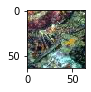

Classified as:  ['spiny lobster', 'langouste', 'rock lobster', 'crawfish', 'crayfish', 'sea crawfish']


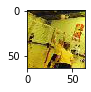

Classified as:  ['volleyball']


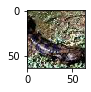

Classified as:  ['European fire salamander', 'Salamandra salamandra']


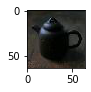

Classified as:  ['teapot']


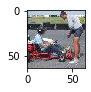

Classified as:  ['go-kart']


In [18]:
for i in range(5):
    f = plt.figure()
    f.add_subplot(1, 5, i + 1)
    index = np.random.randint(90000)
    
    plt.imshow(x_train[index])
    plt.show()
    print('Classified as: ', output['wnid_to_words'][output['label_to_wnid'][y_train[index]]])

## Section 2.1: Customize Model

# ResNet18

In [20]:
from tensorflow.keras.layers import Dropout, Add, Dense, Input, Lambda, Multiply, Flatten, Reshape, Conv2D, GlobalAveragePooling2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model


def initializemodel(mask = None):
    """Initialize model with a certain mask"""
    activationarray = []
    layername = {}
    # if no mask specified, start with no mask
    layer = 0
    if mask is None:
        mask = {}
        initialize = True
    else:
        initialize = False
    
    inputs = Input(shape = [64, 64, 3])
    
    ## Define your model architecture below
    ## For every FC layer (dense layer), follow up with an AddMask line to add the node mask
    ## For every Conv Layer, follow up with an AddFilterMask line to add the filter mask
    
    # ResNet
    # [64] x 1, 1/2
    model = Conv2D(64, (3, 3), padding = 'same', activation = 'relu')(inputs)
#     model = BatchNormalization()(model)
    model, activationarray, layer = AddFilterMask(mask, model, activationarray, layer, initialize = initialize)  
    shortcut = MaxPooling2D((2, 2))(model)
    
    # [64, 64] x 2, 1/2
    model = Conv2D(64, (3, 3), padding = 'same', activation = 'relu')(shortcut)
#     model = BatchNormalization()(model)
    model, activationarray, layer = AddFilterMask(mask, model, activationarray, layer, initialize = initialize)   
    model = Conv2D(64, (3, 3), padding = 'same', activation = 'relu')(model)
#     model = BatchNormalization()(model)
    model, activationarray, layer = AddFilterMask(mask, model, activationarray, layer, initialize = initialize)
    shortcut = Add()([shortcut, model])
    
    model = Conv2D(64, (3, 3), padding = 'same', activation = 'relu')(shortcut)
#     model = BatchNormalization()(model)
    model, activationarray, layer = AddFilterMask(mask, model, activationarray, layer, initialize = initialize)   
    model = Conv2D(64, (3, 3), padding = 'same', activation = 'relu')(model)
#     model = BatchNormalization()(model)
    model, activationarray, layer = AddFilterMask(mask, model, activationarray, layer, initialize = initialize)
    model = Add()([shortcut, model])
    shortcut = MaxPooling2D((2, 2))(model)
    
    # [128, 128] x 2, 1/2
    model = Conv2D(128, (3, 3), padding = 'same', activation = 'relu')(shortcut)
#     model = BatchNormalization()(model)
    model, activationarray, layer = AddFilterMask(mask, model, activationarray, layer, initialize = initialize)   
    model = Conv2D(128, (3, 3), padding = 'same', activation = 'relu')(model)
#     model = BatchNormalization()(model)
    model, activationarray, layer = AddFilterMask(mask, model, activationarray, layer, initialize = initialize)
    shortcut = Conv2D(128, (3, 3), padding = 'same', activation = 'relu')(shortcut)
#     model = BatchNormalization()(model)
    shortcut, activationarray, layer = AddFilterMask(mask, shortcut, activationarray, layer, initialize = initialize)
    shortcut = Add()([shortcut, model])
    
    model = Conv2D(128, (3, 3), padding = 'same', activation = 'relu')(shortcut)
#     model = BatchNormalization()(model)
    model, activationarray, layer = AddFilterMask(mask, model, activationarray, layer, initialize = initialize)   
    model = Conv2D(128, (3, 3), padding = 'same', activation = 'relu')(model)
#     model = BatchNormalization()(model)
    model, activationarray, layer = AddFilterMask(mask, model, activationarray, layer, initialize = initialize)
    model = Add()([shortcut, model])
    shortcut = MaxPooling2D((2, 2))(model)
    
    # [256, 256] x 2, 1/2
    model = Conv2D(256, (3, 3), padding = 'same', activation = 'relu')(shortcut)
#     model = BatchNormalization()(model)
    model, activationarray, layer = AddFilterMask(mask, model, activationarray, layer, initialize = initialize)   
    model = Conv2D(256, (3, 3), padding = 'same', activation = 'relu')(model)
#     model = BatchNormalization()(model)
    model, activationarray, layer = AddFilterMask(mask, model, activationarray, layer, initialize = initialize)
    shortcut = Conv2D(256, (3, 3), padding = 'same', activation = 'relu')(shortcut)
#     model = BatchNormalization()(model)
    shortcut, activationarray, layer = AddFilterMask(mask, shortcut, activationarray, layer, initialize = initialize)
    shortcut = Add()([shortcut, model])
    
    model = Conv2D(256, (3, 3), padding = 'same', activation = 'relu')(shortcut)
#     model = BatchNormalization()(model)
    model, activationarray, layer = AddFilterMask(mask, model, activationarray, layer, initialize = initialize)   
    model = Conv2D(256, (3, 3), padding = 'same', activation = 'relu')(model)
#     model = BatchNormalization()(model)
    model, activationarray, layer = AddFilterMask(mask, model, activationarray, layer, initialize = initialize)
    model = Add()([shortcut, model])
    shortcut = MaxPooling2D((2, 2))(model)
    
    # [512, 512] x 2, 1/2
    model = Conv2D(512, (3, 3), padding = 'same', activation = 'relu')(shortcut)
#     model = BatchNormalization()(model)
    model, activationarray, layer = AddFilterMask(mask, model, activationarray, layer, initialize = initialize)   
    model = Conv2D(512, (3, 3), padding = 'same', activation = 'relu')(model)
#     model = BatchNormalization()(model)
    model, activationarray, layer = AddFilterMask(mask, model, activationarray, layer, initialize = initialize)
    shortcut = Conv2D(512, (3, 3), padding = 'same', activation = 'relu')(shortcut)
#     model = BatchNormalization()(model)
    shortcut, activationarray, layer = AddFilterMask(mask, shortcut, activationarray, layer, initialize = initialize)
    shortcut = Add()([shortcut, model])
    
    model = Conv2D(512, (3, 3), padding = 'same', activation = 'relu')(shortcut)
#     model = BatchNormalization()(model)
    model, activationarray, layer = AddFilterMask(mask, model, activationarray, layer, initialize = initialize)   
    model = Conv2D(512, (3, 3), padding = 'same', activation = 'relu')(model)
#     model = BatchNormalization()(model)
    model, activationarray, layer = AddFilterMask(mask, model, activationarray, layer, initialize = initialize)
    model = Add()([shortcut, model])
    
    model = GlobalAveragePooling2D()(model)  

    # Multiply by mask on nodes (Drop nodes)
    out = Dense(200, activation = 'softmax')(model)
    
    model = Model(inputs = [inputs], outputs = [out])    
    activationmodel = Model(inputs = [inputs], outputs = activationarray)
    
    return mask, model, activationmodel

# VGG19

In [ ]:
from tensorflow.keras.layers import Dropout, Dense, Input, Lambda, Multiply, Flatten, Reshape, Conv2D, AveragePooling2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model

def initializemodel(mask = None):
    """Initialize model with a certain mask"""
    activationarray = []
    layername = {}
    # if no mask specified, start with no mask
    layer = 0
    if mask is None:
        mask = {}
        initialize = True
    else:
        initialize = False
    
    inputs = Input(shape = [64, 64, 3])
    
    ## Define your model architecture below
    ## For every FC layer (dense layer), follow up with an AddMask line to add the node mask
    ## For every Conv Layer, follow up with an AddFilterMask line to add the filter mask
    
    # VGG-19
    model = Conv2D(64, (3, 3), padding = 'same', activation = 'relu')(inputs)
#     model = BatchNormalization()(model)
    model, activationarray, layer = AddFilterMask(mask, model, activationarray, layer, initialize = initialize)   
    model = Conv2D(64, (3, 3), padding = 'same', activation = 'relu')(model)
    model = BatchNormalization()(model)
    model, activationarray, layer = AddFilterMask(mask, model, activationarray, layer, initialize = initialize)   
    model = MaxPooling2D((2, 2))(model)
    
    model = Conv2D(128, (3, 3), padding = 'same', activation = 'relu')(model)
#     model = BatchNormalization()(model)
    model, activationarray, layer = AddFilterMask(mask, model, activationarray, layer, initialize = initialize)
    model = Conv2D(128, (3, 3), padding = 'same', activation = 'relu')(model)
    model = BatchNormalization()(model)
    model, activationarray, layer = AddFilterMask(mask, model, activationarray, layer, initialize = initialize)
    model = MaxPooling2D((2, 2))(model)
    
    model = Conv2D(256, (3, 3), padding = 'same', activation = 'relu')(model)
#     model = BatchNormalization()(model)
    model, activationarray, layer = AddFilterMask(mask, model, activationarray, layer, initialize = initialize)
    model = Conv2D(256, (3, 3), padding = 'same', activation = 'relu')(model)
#     model = BatchNormalization()(model)
    model, activationarray, layer = AddFilterMask(mask, model, activationarray, layer, initialize = initialize)
    model = Conv2D(256, (3, 3), padding = 'same', activation = 'relu')(model)
#     model = BatchNormalization()(model)
    model, activationarray, layer = AddFilterMask(mask, model, activationarray, layer, initialize = initialize)
    model = Conv2D(256, (3, 3), padding = 'same', activation = 'relu')(model)
    model = BatchNormalization()(model)
    model, activationarray, layer = AddFilterMask(mask, model, activationarray, layer, initialize = initialize)

    model = MaxPooling2D((2, 2))(model)
    
    model = Conv2D(512, (3, 3), padding = 'same', activation = 'relu')(model)
#     model = BatchNormalization()(model)
    model, activationarray, layer = AddFilterMask(mask, model, activationarray, layer, initialize = initialize)
    model = Conv2D(512, (3, 3), padding = 'same', activation = 'relu')(model)
#     model = BatchNormalization()(model)
    model, activationarray, layer = AddFilterMask(mask, model, activationarray, layer, initialize = initialize)
    model = Conv2D(512, (3, 3), padding = 'same', activation = 'relu')(model)
#     model = BatchNormalization()(model)
    model, activationarray, layer = AddFilterMask(mask, model, activationarray, layer, initialize = initialize)
    model = Conv2D(512, (3, 3), padding = 'same', activation = 'relu')(model)
    model = BatchNormalization()(model)
    model, activationarray, layer = AddFilterMask(mask, model, activationarray, layer, initialize = initialize)
    model = MaxPooling2D((2, 2))(model)
    
    model = Conv2D(512, (3, 3), padding = 'same', activation = 'relu')(model)
#     model = BatchNormalization()(model)
    model, activationarray, layer = AddFilterMask(mask, model, activationarray, layer, initialize = initialize)
    model = Conv2D(512, (3, 3), padding = 'same', activation = 'relu')(model)
#     model = BatchNormalization()(model)
    model, activationarray, layer = AddFilterMask(mask, model, activationarray, layer, initialize = initialize)
    model = Conv2D(512, (3, 3), padding = 'same', activation = 'relu')(model)
#     model = BatchNormalization()(model)
    model, activationarray, layer = AddFilterMask(mask, model, activationarray, layer, initialize = initialize)
    model = Conv2D(512, (3, 3), padding = 'same', activation = 'relu')(model)
    model = BatchNormalization()(model)
    model, activationarray, layer = AddFilterMask(mask, model, activationarray, layer, initialize = initialize)
    model = MaxPooling2D((2, 2))(model)
    
    model = Flatten()(model)

    # Multiply by mask on nodes (Drop nodes)
    model = Dense(1024, activation = 'relu')(model)
    
    out = Dense(200, activation = 'softmax')(model)
    
    model = Model(inputs = [inputs], outputs = [out])    
    activationmodel = Model(inputs = [inputs], outputs = activationarray)
    
    return mask, model, activationmodel

## Section 2.2: Model Evaluation

In [ ]:
## Model evaluation to compare all metrics
cache = generatemodelaugment(opt = SGD(lr = 0.1), loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'], batch_size = 32, callbacks = [EarlyStopping(monitor='val_loss', mode = 'min', verbose=0, patience=10)], num_epochs = 100, numtrials = 15, percentile = 0.5, verbose = 1, printvalue = True, printmask = False, printactivation = False)

## Change your model name accordingly
modelname = 'tinyimagenet_resnet18_evaluate'

## If want to print oraclecomparison graph, set to oracle = True (only for oraclemodel)
printgraph(cache, modelname, numtrials = 15, oracle = False)
savefile(cache, modelname)

>>>     Random seed number: 0

>>> Currently doing min mask <<<
Epoch 1/100
2812/2812 [==============================] - 96s 34ms/step - loss: 5.1016 - accuracy: 0.0165 - val_loss: 4.7861 - val_accuracy: 0.0423
Epoch 2/100
2812/2812 [==============================] - 97s 34ms/step - loss: 4.6848 - accuracy: 0.0554 - val_loss: 4.5204 - val_accuracy: 0.0844
Epoch 3/100
2812/2812 [==============================] - 97s 34ms/step - loss: 4.3208 - accuracy: 0.0991 - val_loss: 4.0720 - val_accuracy: 0.1317
Epoch 4/100
2812/2812 [==============================] - 96s 34ms/step - loss: 4.0144 - accuracy: 0.1422 - val_loss: 3.8963 - val_accuracy: 0.1685
Epoch 5/100
2812/2812 [==============================] - 95s 34ms/step - loss: 3.7595 - accuracy: 0.1819 - val_loss: 3.5680 - val_accuracy: 0.2184
Epoch 6/100
2812/2812 [==============================] - 97s 34ms/step - loss: 3.5440 - accuracy: 0.2161 - val_loss: 3.4514 - val_accuracy: 0.2388
Epoch 7/100
2812/2812 [==============================]